In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import heapq
import random

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset

from torch import nn

import youtokentome as yttm


def load_war_and_piece_chunks(fname, chunk_size=200):
    with open(fname, 'r', encoding="utf8") as fin:
        full_text = fin.read()
    return [full_text[start:start + chunk_size] for start in range(0, len(full_text), chunk_size // 2)]

def save_texts_to_file(texts, out_file):
    with open(out_file, 'w', encoding="utf8") as outf:
        outf.write('\n'.join(texts))

def ensure_length(txt, out_len, pad_value):
    if len(txt) < out_len:
        txt = list(txt) + [pad_value] * (out_len - len(txt))
    else:
        txt = txt[:out_len]
    return txt


class LanguageModelDataset(Dataset):
    def __init__(self, token_ids, chunk_length=100, pad_value=0):
        self.token_ids = token_ids
        self.chunk_length = chunk_length
        self.pad_value = pad_value

    def __len__(self):
        return len(self.token_ids)

    def __getitem__(self, item):
        text = self.token_ids[item]
        start_i = random.randint(0, max(0, len(text) - self.chunk_length - 1))
        chunk = text[start_i : start_i + self.chunk_length + 1]

        seed_part = chunk[:-1]
        target_part = chunk[1:]

        seed_part = ensure_length(seed_part, self.chunk_length, self.pad_value)
        target_part = ensure_length(target_part, self.chunk_length, self.pad_value)

        seed_part = np.array(seed_part)
        target_part = np.array(target_part)

        return seed_part, target_part



In [2]:
all_chunks = load_war_and_piece_chunks('war_and_peace.txt')
len(all_chunks)

7976

In [3]:
print(len(all_chunks[1]))

200


In [4]:
np.random.shuffle(all_chunks)

TRAIN_SPLIT = int(len(all_chunks) * 0.7)
train_texts = all_chunks[:TRAIN_SPLIT]
test_texts = all_chunks[TRAIN_SPLIT:]

print(len(train_texts))
print(len(test_texts))

5583
2393


In [5]:
BPE_MODEL_FILENAME = 'war_and_peace_bpe.yttm'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [6]:
TRAIN_TEXTS_FILENAME = 'war_and_peace_bpe_train.txt'

save_texts_to_file(train_texts, TRAIN_TEXTS_FILENAME)
yttm.BPE.train(data=TRAIN_TEXTS_FILENAME, vocab_size=1000, model=BPE_MODEL_FILENAME)

In [7]:
tokenizer = yttm.BPE(BPE_MODEL_FILENAME)


In [8]:
print(tokenizer.vocab())

['<PAD>', '<UNK>', '<BOS>', '<EOS>', '▁', 'о', 'а', 'е', 'и', 'н', 'т', 'с', 'л', 'в', 'р', 'к', ',', 'д', 'м', 'у', 'п', 'я', 'г', 'ь', 'ы', 'з', 'б', '.', 'ч', 'й', '-', 'ж', 'e', 'ш', 'х', 'ю', 's', 'ц', 'a', 'n', 'r', 'i', 'u', 'o', 't', 'щ', 'э', 'П', 'l', 'Н', 'ф', 'В', 'А', 'm', 'd', 'c', 'О', '?', '!', 'К', 'Д', 'Б', 'p', 'М', '"', 'Р', 'v', '(', "'", ')', 'С', 'И', ';', '1', 'ё', 'Т', 'h', ':', 'Я', 'q', '2', 'f', 'Г', 'ъ', 'g', 'Э', 'b', '3', 'Е', '0', 'Ч', '4', '5', ']', '[', 'I', 'j', 'Л', 'z', 'M', '8', 'З', '7', '6', 'У', 'A', '9', 'V', 'x', 'Ж', 'L', 'Ф', 'X', 'Х', 'y', 'Ш', 'C', 'B', 'J', 'P', 'N', 'E', 'k', 'S', 'D', 'R', 'Q', 'w', 'Ц', 'T', 'U', 'O', 'F', 'Ю', 'G', '`', 'W', 'K', 'H', 'Ь', 'Й', 'Z', '&', '#', 'Щ', '/', '▁с', '▁п', '▁в', '▁н', 'то', '▁о', '▁и', '▁к', 'ал', 'го', 'ра', 'ст', 'но', '▁-', '▁по', 'ен', '▁д', 'ро', 'ел', '▁б', 'ер', '▁не', 'ко', 'во', 'ка', '▁ч', '▁м', 'ри', '▁на', 'ло', 'ть', 'на', 'ли', '▁з', '▁е', 'ла', '▁т', '▁у', 'ре', 'ва', 'ни', 'ся'

In [9]:
print(tokenizer.encode(train_texts[:1]))

[[151, 7, 869, 210, 409, 450, 146, 184, 199, 383, 34, 466, 302, 33, 537, 183, 11, 175, 212, 29, 820, 186, 16, 153, 385, 18, 206, 219, 356, 15, 146, 162, 193, 157, 771, 256, 163, 309, 200, 155, 358, 343, 219, 653, 158, 558, 248, 13, 157, 173, 29, 830, 219, 204, 6, 160, 685, 176, 304, 176, 167, 160, 30, 191, 11, 327, 319, 5, 186, 344, 178, 160, 30, 50, 602, 327, 69, 16, 261]]


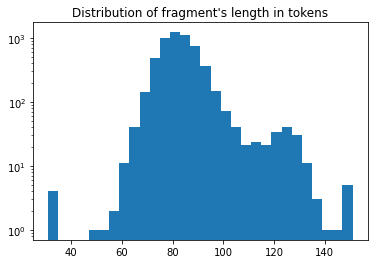

In [10]:
train_token_ids = tokenizer.encode(train_texts, bos=True, eos=True) #begin of seq, end of seq
test_token_ids = tokenizer.encode(test_texts, bos=True, eos=True)
plt.hist([len(sent) for sent in train_token_ids], bins=30)
plt.title("Distribution of fragment's length in tokens")
plt.yscale('log')

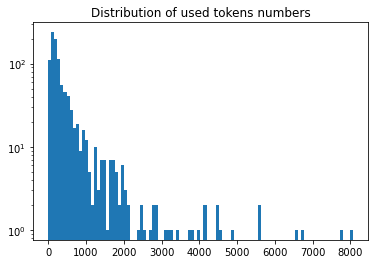

In [11]:
token_counts = np.bincount([token_id for text in train_token_ids for token_id in text])
plt.hist(token_counts, bins=100)
plt.title('Distribution of used tokens numbers')
plt.yscale('log')

In [12]:
unknown_subwords_in_test = sum(1 for text in test_token_ids for token_id in text if token_id == 1)
print('Number with unknown N-gramms', unknown_subwords_in_test)

Number with unknown N-gramms 2


In [13]:
CHUNK_LENGTH = 80

train_dataset = LanguageModelDataset(train_token_ids, chunk_length=CHUNK_LENGTH)
test_dataset = LanguageModelDataset(test_token_ids, chunk_length=CHUNK_LENGTH)

In [14]:
train_dataset[0]

(array([  2, 151,   7, 869, 210, 409, 450, 146, 184, 199, 383,  34, 466,
        302,  33, 537, 183,  11, 175, 212,  29, 820, 186,  16, 153, 385,
         18, 206, 219, 356,  15, 146, 162, 193, 157, 771, 256, 163, 309,
        200, 155, 358, 343, 219, 653, 158, 558, 248,  13, 157, 173,  29,
        830, 219, 204,   6, 160, 685, 176, 304, 176, 167, 160,  30, 191,
         11, 327, 319,   5, 186, 344, 178, 160,  30,  50, 602, 327,  69,
         16, 261]),
 array([151,   7, 869, 210, 409, 450, 146, 184, 199, 383,  34, 466, 302,
         33, 537, 183,  11, 175, 212,  29, 820, 186,  16, 153, 385,  18,
        206, 219, 356,  15, 146, 162, 193, 157, 771, 256, 163, 309, 200,
        155, 358, 343, 219, 653, 158, 558, 248,  13, 157, 173,  29, 830,
        219, 204,   6, 160, 685, 176, 304, 176, 167, 160,  30, 191,  11,
        327, 319,   5, 186, 344, 178, 160,  30,  50, 602, 327,  69,  16,
        261,   3]))

In [15]:
tokenizer.decode(list(train_dataset[0]))

['<BOS> ое чувство отдыха среди тех роскошных условий жизни, к которым он привык с детства. Кроме того ему было приятно после австрийского приема поговорить хоть не по-русски (они говорили по-французски), но',
 'ое чувство отдыха среди тех роскошных условий жизни, к которым он привык с детства. Кроме того ему было приятно после австрийского приема поговорить хоть не по-русски (они говорили по-французски), но<EOS>']

In [94]:
def make_target_dependency_mask(length):
    full_mask = torch.ones(length, length)
    ignore_mask = torch.tril(full_mask) < 1
    full_mask.masked_fill_(ignore_mask, float('-inf'))
    full_mask.masked_fill_(~ignore_mask, 0)
    return full_mask
make_target_dependency_mask(10)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [17]:
def make_positional_encoding(max_length, embedding_size):
    time = np.pi * torch.arange(0, max_length).float()
    freq_dividers = torch.arange(1, embedding_size // 2 + 1).float()
    inputs = time[:, None] / freq_dividers[None, :]
    
    result = torch.zeros(max_length, embedding_size)
    result[:, 0::2] = torch.sin(inputs)
    result[:, 1::2] = torch.cos(inputs)
    return result


torch.Size([30, 30])

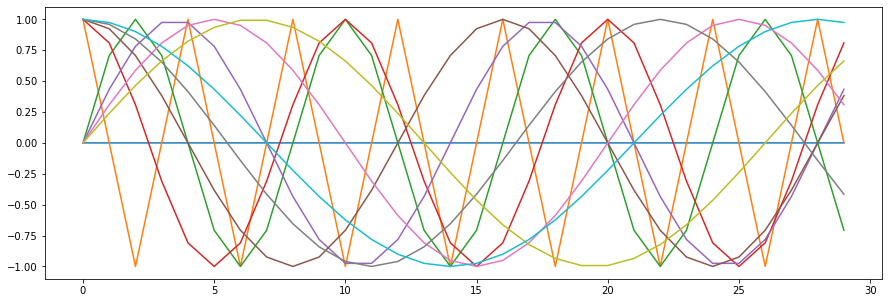

In [18]:
sample_pos_codes = make_positional_encoding(30, 30)
plt.plot(sample_pos_codes[:, ::3])
plt.gcf().set_size_inches((15, 5))
sample_pos_codes[:, :].shape

In [19]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, backbone, emb_dropout=0.0):
        super().__init__()
        self.embedding_size = embedding_size
        self.embeddings = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.emb_dropout = nn.Dropout(emb_dropout)
        self.backbone = backbone
        self.out = nn.Linear(embedding_size, vocab_size)

    def forward(self, seed_token_ids):
        """
            seed_token_ids - BatchSize x MaxInLen
        """
        batch_size, max_in_length = seed_token_ids.shape

        seed_padding_mask = seed_token_ids == 0
        dependency_mask = make_target_dependency_mask(max_in_length) \
            .to(seed_token_ids.device)

        seed_embs = self.embeddings(seed_token_ids)  # BatchSize x MaxInLen x EmbSize
        pos_codes = make_positional_encoding(max_in_length,
                                             self.embedding_size).unsqueeze(0).to(seed_embs.device)
        seed_embs = seed_embs + pos_codes
        seed_embs = self.emb_dropout(seed_embs)

        # BatchSize x TargetLen x EmbSize
        target_features = seed_embs
        target_features = self.backbone(seed_embs,
                                        mask=dependency_mask,
                                        src_key_padding_mask=seed_padding_mask)
        logits = self.out(target_features)  # BatchSize x TargetLen x VocabSize
        return logits

In [20]:
def lm_cross_entropy(pred, target):
    """
    pred - BatchSize x TargetLen x VocabSize
    target - BatchSize x TargetLen
    """
    pred_flat = pred.view(-1, pred.shape[-1])  # BatchSize*TargetLen x VocabSize
    target_flat = target.view(-1).to(torch.long)  # BatchSize*TargetLen
    return F.cross_entropy(pred_flat, target_flat, ignore_index=0)


def lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                      patience=20,
                                                      factor=0.5,
                                                      verbose=True)

In [21]:
class BatchFirstTransformerEncoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.impl = nn.TransformerEncoder(*args, **kwargs)
        self.initialize_weights()
    
    def forward(self, src, *args, **kwargs):
        src = src.transpose(0, 1).contiguous()  # MaxInLen  x BatchSize x EmbSize
        result = self.impl(src, *args, **kwargs)  # TargetLen x BatchSize x EmbSize
        result = result.transpose(0, 1).contiguous()  # BatchSize x TargetLen x EmbSize
        return result
    
    def initialize_weights(self):
        for param in self.impl.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
                

In [22]:
def get_params_number(model):
    return sum(t.numel() for t in model.parameters())

In [23]:
from torch.nn.modules.transformer import TransformerEncoderLayer
torch_transf_model = LanguageModel(tokenizer.vocab_size(),
                                   256,
                                   BatchFirstTransformerEncoder(
                                       TransformerEncoderLayer(
                                           d_model=256,
                                           nhead=16,
                                           dim_feedforward=512,
                                           dropout=0.1),
                                       num_layers=3),
                                   emb_dropout=0.1)
print('Количество параметров', get_params_number(torch_transf_model))

Количество параметров 2094312


In [24]:
from torch.utils.data import DataLoader
import copy
import datetime
import random
import traceback

def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Недопустимый тип данных {}'.format(type(data)))
    
def train_eval_loop(model, train_dataset, val_dataset, criterion,
                    lr=1e-4, epoch_n=10, batch_size=32,
                    device=None, early_stopping_patience=10, l2_reg_alpha=0,
                    max_batches_per_epoch_train=10000,
                    max_batches_per_epoch_val=1000,
                    data_loader_ctor=DataLoader,
                    optimizer_ctor=None,
                    lr_scheduler_ctor=None,
                    shuffle_train=True,
                    dataloader_workers_n=0):
    """
    Цикл для обучения модели. После каждой эпохи качество модели оценивается по отложенной выборке.
    :param model: torch.nn.Module - обучаемая модель
    :param train_dataset: torch.utils.data.Dataset - данные для обучения
    :param val_dataset: torch.utils.data.Dataset - данные для оценки качества
    :param criterion: функция потерь для настройки модели
    :param lr: скорость обучения
    :param epoch_n: максимальное количество эпох
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param early_stopping_patience: наибольшее количество эпох, в течение которых допускается
        отсутствие улучшения модели, чтобы обучение продолжалось.
    :param l2_reg_alpha: коэффициент L2-регуляризации
    :param max_batches_per_epoch_train: максимальное количество итераций на одну эпоху обучения
    :param max_batches_per_epoch_val: максимальное количество итераций на одну эпоху валидации
    :param data_loader_ctor: функция для создания объекта, преобразующего датасет в батчи
        (по умолчанию torch.utils.data.DataLoader)
    :return: кортеж из двух элементов:
        - среднее значение функции потерь на валидации на лучшей эпохе
        - лучшая модель
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), lr=lr)

    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None

    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size, shuffle=shuffle_train,
                                        num_workers=dataloader_workers_n)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size, shuffle=False,
                                      num_workers=dataloader_workers_n)

    best_val_loss = float('inf')
    best_epoch_i = 0
    best_model = copy.deepcopy(model)

    for epoch_i in range(epoch_n):
        try:
            epoch_start = datetime.datetime.now()
            print('Эпоха {}'.format(epoch_i))

            model.train()
            mean_train_loss = 0
            train_batches_n = 0
            for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
                if batch_i > max_batches_per_epoch_train:
                    break

                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)
                pred = model(batch_x)
                loss = criterion(pred, batch_y)

                model.zero_grad()
                loss.backward()

                optimizer.step()

                mean_train_loss += float(loss)
                train_batches_n += 1

            mean_train_loss /= train_batches_n
            print('Эпоха: {} итераций, {:0.2f} сек'.format(train_batches_n,
                                                           (datetime.datetime.now() - epoch_start).total_seconds()))
            print('Среднее значение функции потерь на обучении', mean_train_loss)



            model.eval()
            mean_val_loss = 0
            val_batches_n = 0

            with torch.no_grad():
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                    if batch_i > max_batches_per_epoch_val:
                        break

                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

                    pred = model(batch_x)
                    loss = criterion(pred, batch_y)

                    mean_val_loss += float(loss)
                    val_batches_n += 1

            mean_val_loss /= val_batches_n
            print('Среднее значение функции потерь на валидации', mean_val_loss)

            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = copy.deepcopy(model)
                print('Новая лучшая модель!')
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format(
                    early_stopping_patience))
                break

            if lr_scheduler is not None:
                lr_scheduler.step(mean_val_loss)

            print()
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
        except Exception as ex:
            print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))
            break

    return best_val_loss, best_model

In [90]:
(best_val_loss, best_torch_transf_model) = train_eval_loop(torch_transf_model,
                                                           train_dataset,
                                                           test_dataset,
                                                           lm_cross_entropy,
                                                           lr=2e-3,
                                                           epoch_n=200,
                                                           batch_size=64,
                                                           device=None,
                                                           early_stopping_patience=15,
                                                           max_batches_per_epoch_train=100,
                                                           max_batches_per_epoch_val=100,
                                                           lr_scheduler_ctor=lr_scheduler)

Эпоха 0
Эпоха: 88 итераций, 206.27 сек
Среднее значение функции потерь на обучении 6.222075386480852
Среднее значение функции потерь на валидации 5.898277320359883
Новая лучшая модель!

Эпоха 1
Эпоха: 88 итераций, 211.34 сек
Среднее значение функции потерь на обучении 5.135201502930034
Среднее значение функции потерь на валидации 4.4371529754839445
Новая лучшая модель!

Эпоха 2
Эпоха: 88 итераций, 220.71 сек
Среднее значение функции потерь на обучении 4.330204416405071
Среднее значение функции потерь на валидации 4.110404002039056
Новая лучшая модель!

Эпоха 3
Эпоха: 88 итераций, 223.59 сек
Среднее значение функции потерь на обучении 4.0596039755777875
Среднее значение функции потерь на валидации 3.909200122481898
Новая лучшая модель!

Эпоха 4
Эпоха: 88 итераций, 228.37 сек
Среднее значение функции потерь на обучении 3.882873304865577
Среднее значение функции потерь на валидации 3.7766287452296208
Новая лучшая модель!

Эпоха 5
Эпоха: 88 итераций, 226.77 сек
Среднее значение функции пот

In [91]:
torch.save(best_torch_transf_model.state_dict(), './models/war_and_peace_torch_transf_best.pth')


In [33]:
torch_transf_model.load_state_dict(torch.load('./models/war_and_peace_torch_transf_best.pth'))

<All keys matched successfully>

In [25]:
class GreedyGenerator:
    def __init__(self, model, tokenizer, device='cuda', eos_token_id=3):
        self.model = model
        self.tokenizer = tokenizer
        self.device = torch.device(device)
        self.eos_token_id = eos_token_id

    def __call__(self, seed_text, max_steps_n=40):
        seed_tokens = self.tokenizer.encode([seed_text])[0]

        for _ in range(max_steps_n):
            in_batch = torch.tensor(seed_tokens).unsqueeze(0)
            best_next_token = self.model(in_batch)[0, -1].argmax()
            if best_next_token == self.eos_token_id:
                break

            seed_tokens.append(best_next_token)

        return self.tokenizer.decode([seed_tokens])[0]


class BeamGenerator:
    def __init__(self, model, tokenizer, device='cuda', eos_token_id=3):
        self.model = model
        self.tokenizer = tokenizer
        self.device = torch.device(device)
        self.eos_token_id = eos_token_id

    def __call__(self, seed_text, max_steps_n=40, return_hypotheses_n=5, beamsize=5):
        seed_tokens = self.tokenizer.encode([seed_text])[0]
        initial_length = len(seed_tokens)

        partial_hypotheses = [(0, seed_tokens)]
        final_hypotheses = []

        while len(partial_hypotheses) > 0:
            cur_partial_score, cur_partial_hypothesis = heapq.heappop(partial_hypotheses)

            in_batch = torch.tensor(cur_partial_hypothesis).unsqueeze(0)
            next_tokens_logits = self.model(in_batch)[0, -1]
            next_tokens_logproba = F.log_softmax(next_tokens_logits)
            topk_continuations = next_tokens_logproba.topk(beamsize)

            for token_score, token_idx in zip(topk_continuations.values, topk_continuations.indices):
                token_score = float(token_score)
                token_idx = int(token_idx)

                old_denorm_score = cur_partial_score * np.sqrt(len(cur_partial_hypothesis))
                new_score = (old_denorm_score - token_score) / np.sqrt(len(cur_partial_hypothesis) + 1)

                new_hypothesis = cur_partial_hypothesis + [token_idx]
                new_item = (new_score, new_hypothesis)

                if token_idx == self.eos_token_id or len(new_hypothesis) - initial_length >= max_steps_n:
                    final_hypotheses.append(new_item)
                else:
                    heapq.heappush(partial_hypotheses, new_item)

            if len(partial_hypotheses) > beamsize:
                partial_hypotheses = heapq.nsmallest(beamsize, partial_hypotheses)
                heapq.heapify(partial_hypotheses)

        final_scores, final_token_lists = zip(*final_hypotheses)
        final_texts = self.tokenizer.decode(list(final_token_lists))

        result = list(zip(final_scores, final_texts))
        result.sort()
        result = result[:return_hypotheses_n]

        return result

In [34]:
greedy_Generator = GreedyGenerator(torch_transf_model, tokenizer)

In [35]:
%%time

print(greedy_Generator('Кто я?'))

Кто я? поудь князь, по об князьфипо по L;ениевшийn голоР дляt, чтобыq по были ду, по доко Он ему по были ду,моная дочь
Wall time: 518 ms


In [36]:
beam_generator = BeamGenerator(torch_transf_model, tokenizer)

In [37]:
%%time
variants = beam_generator('Наполеон', beamsize=15, return_hypotheses_n=1)

for score, pred in variants:
    print('****')
    print(score)
    print(pred)
    print()

****
6.897777857046356
Наполеоналануюстз моilesб по C;ение рассati И, ЯA по были jли,линияя Днят на Ж хотел по C;ениевший

Wall time: 5.9 s


In [79]:
def my_multihead_attention(queries, keys, values,
                           keys_padding_mask, dependency_mask,
                           is_training,
                           weights_dropout):
    """
    queries - BatchSize x ValuesLen x HeadN x KeySize
    keys - BatchSize x KeysLen x HeadN x KeySize
    values - BatchSize x KeysLen x HeadN x ValueSize
    keys_padding_mask - BatchSize x KeysLen
    dependency_mask - ValuesLen x KeysLen
    is_training - bool
    weights_dropout - float
    
    result - tuple of two:
        - BatchSize x ValuesLen x HeadN x ValueSize - resulting features
        - BatchSize x ValuesLen x KeysLen x HeadN - attention map
        queries torch.Size([512, 16, 80, 16])
        keys    torch.Size([512, 80, 16, 16])
    """
#     print('queries', queries.shape)
#     print('keys', keys.shape)
    # BatchSize x ValuesLen x KeysLen x HeadN
    relevances = torch.einsum('bhvs,bkhs->bvkh', (queries, keys))
#     print(relevances.shape)
    # замаскировать элементы, выходящие за длины последовательностей ключей
    padding_mask_expanded = keys_padding_mask[None,:,  :, None].expand_as(relevances)
    relevances.masked_fill_(padding_mask_expanded, float('-inf'))
    
    # замаскировать пары <выходная позиция, входная позиция>
    relevances = relevances + dependency_mask[ :,None, :, None].expand_as(relevances)
    
    normed_rels = F.softmax(relevances, dim=2)    
    normed_rels = F.dropout(normed_rels, weights_dropout, is_training)
    
    # BatchSize x ValuesLen x KeysLen x HeadN x 1
    normed_rels_expanded = normed_rels.unsqueeze(-1)
    
    # BatchSize x 1 x KeysLen x HeadN x ValueSize
    values_expanded = values.unsqueeze(1)
    
    # BatchSize x ValuesLen x KeysLen x HeadN x ValueSize
    weighted_values = normed_rels_expanded * values_expanded
    result = weighted_values.sum(2)  # BatchSize x ValuesLen x HeadN x ValueSize
    
    return result, normed_rels

In [80]:
class MyMultiheadSelfAttention(nn.Module):
    def __init__(self, model_size, n_heads, dropout=0):
        super().__init__()
        assert model_size % n_heads == 0
        self.n_heads = n_heads
        
        self.queries_proj = nn.Linear(model_size, model_size)
        self.keys_proj = nn.Linear(model_size, model_size)
        self.values_proj = nn.Linear(model_size, model_size)
        
        self.dropout = dropout
        
        self.last_attention_map = None
        
    def forward(self, sequence, padding_mask, dependency_mask):
        batch_size, max_len, model_size = sequence.shape
        
        queries_flat = self.queries_proj(sequence)
        queries = queries_flat.view(batch_size, self.n_heads, max_len,  -1)
        
        keys_flat = self.keys_proj(sequence)
        keys = keys_flat.view(batch_size, max_len, self.n_heads, -1)
        
        values_flat = self.keys_proj(sequence)
        values = values_flat.view(batch_size, max_len, self.n_heads, -1)
        
        result, att_map = my_multihead_attention(queries, keys, values,
                                                 padding_mask, dependency_mask,
                                                 self.training, self.dropout)
        result_flat = result.view(batch_size, max_len, model_size)
        self.last_attention_map = att_map.detach()
        
        return result_flat

In [70]:
torch.ones(2,2).unsqueeze(-1)
torch.ones(2,2).view(2,2,-1)

tensor([[[1.],
         [1.]],

        [[1.],
         [1.]]])

In [55]:
class MyTransformerEncoderLayer(nn.Module):
    def __init__(self, model_size, n_heads, dim_feedforward, dropout):
        super().__init__()
        self.self_attention = MyMultiheadSelfAttention(model_size, n_heads, dropout=dropout)
        
        self.first_dropout = nn.Dropout(dropout)
        self.first_norm = nn.LayerNorm(model_size)
        
        self.feedforward = nn.Sequential(
            nn.Linear(model_size, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, model_size),
            nn.Dropout(dropout)
        )
        
        self.second_norm = nn.LayerNorm(model_size)
    
    def forward(self, sequence, padding_mask, dependency_mask):
        att_features = self.self_attention(sequence, padding_mask, dependency_mask)
        
        sequence = sequence + self.first_dropout(att_features)
        sequence = self.first_norm(sequence)
        
        sequence = sequence + self.feedforward(sequence)
        sequence = self.second_norm(sequence)
        
        return sequence

In [56]:
class MyTransformerEncoder(nn.Module):
    def __init__(self, n_layers, **layer_kwargs):
        super().__init__()
        self.layers = nn.ModuleList([
            MyTransformerEncoderLayer(**layer_kwargs)
            for _ in range(n_layers)
        ])
        self.initialize_weights()
        
    def forward(self, sequence, mask, src_key_padding_mask):
        for layer in self.layers:
            sequence = layer(sequence, mask, src_key_padding_mask)
        return sequence

    def initialize_weights(self):
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

In [81]:
my_transf_model = LanguageModel(tokenizer.vocab_size(),
                                128,
                                MyTransformerEncoder(
                                    n_layers=3,
                                    model_size=128,
                                    n_heads=8,
                                    dim_feedforward=512,
                                    dropout=0.1),
                                emb_dropout=0.1)
print('Количество параметров', get_params_number(my_transf_model))

Количество параметров 802280


In [82]:
(best_val_loss,
 best_my_transf_model) = train_eval_loop(my_transf_model,
                                         train_dataset,
                                         test_dataset,
                                         lm_cross_entropy,
                                         lr=2e-3,
                                         epoch_n=10,
                                         batch_size=64,
                                         device=None,
                                         early_stopping_patience=50,
                                         max_batches_per_epoch_train=200,
                                         max_batches_per_epoch_val=200,
                                         lr_scheduler_ctor=lr_scheduler)

Эпоха 0
Эпоха: 88 итераций, 264.61 сек
Среднее значение функции потерь на обучении 6.27985400503332
Среднее значение функции потерь на валидации 6.225182094072041
Новая лучшая модель!

Эпоха 1
Эпоха: 88 итераций, 262.81 сек
Среднее значение функции потерь на обучении 6.105711042881012
Среднее значение функции потерь на валидации 5.840104241120188
Новая лучшая модель!

Эпоха 2
Эпоха: 88 итераций, 278.97 сек
Среднее значение функции потерь на обучении 5.579859451814131
Среднее значение функции потерь на валидации 5.063216372540123
Новая лучшая модель!

Эпоха 3
Эпоха: 88 итераций, 275.10 сек
Среднее значение функции потерь на обучении 4.8604871955784885
Среднее значение функции потерь на валидации 4.476697306883962
Новая лучшая модель!

Эпоха 4
Эпоха: 88 итераций, 281.62 сек
Среднее значение функции потерь на обучении 4.47039963982322
Среднее значение функции потерь на валидации 4.289916854155691
Новая лучшая модель!

Эпоха 5
Эпоха: 88 итераций, 306.13 сек
Среднее значение функции потерь 

In [92]:
torch.save(best_my_transf_model.state_dict(), './models/war_and_peace_my_transf_best.pth')

In [93]:
my_greedy_generator = GreedyGenerator(my_transf_model, tokenizer)
my_greedy_generator('сказала княжна, оглядывая Андре')

'сказала княжна, оглядывая Андрей, сказала Анна Михайловны Михайловны Михайловны Анна Михайловны Михайловны Михайловны Михайловны Михайловныны Михайловныныныныныныныныныныныныныныныныныны'

In [89]:
def plot_attention_maps(model, input_string, tokenizer, device='cpu', max_heads=2, figsize=(16, 10)):
    device = torch.device(device)

    token_ids = tokenizer.encode([input_string])[0]

    token_strs = [tokenizer.id_to_subword(i) for i in token_ids]
    in_len = len(token_ids)
    ticks = np.arange(0, in_len)

    model.to(device)
    model.eval()

    in_batch = torch.tensor(token_ids).unsqueeze(0).to(device)
    model(in_batch)

    for module in model.modules():
        if isinstance(module, MyMultiheadSelfAttention):
            cur_last_attention_map = module.last_attention_map[0].cpu().numpy()
            n_heads = cur_last_attention_map.shape[-1]
            n_heads_to_vis = min(n_heads, max_heads)

            fig, axes = plt.subplots(1, n_heads_to_vis)
            fig.set_size_inches(figsize)
            for head_i in range(n_heads_to_vis):
                ax = axes[head_i]
                ax.imshow(cur_last_attention_map[..., head_i])

                ax.set_yticks(ticks)
                ax.set_ylim(bottom=in_len - 0.5, top=-0.5)
                ax.set_yticklabels(token_strs)

                ax.set_xticks(ticks)
                ax.set_xticklabels(token_strs)

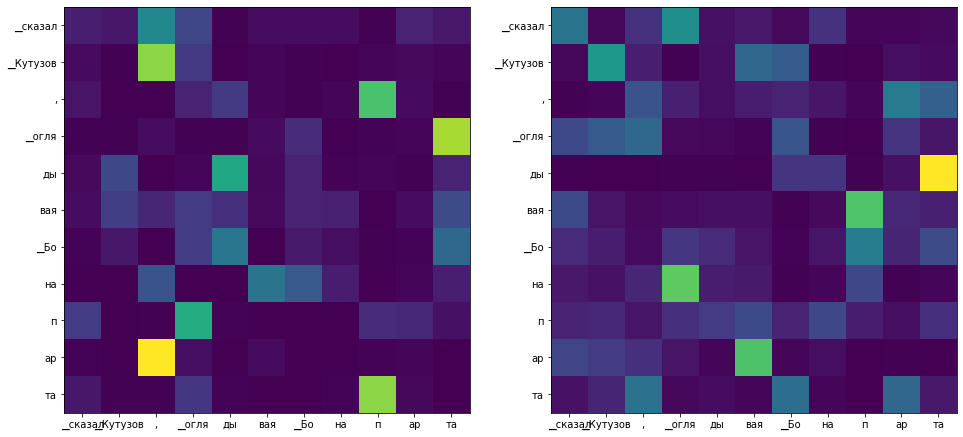

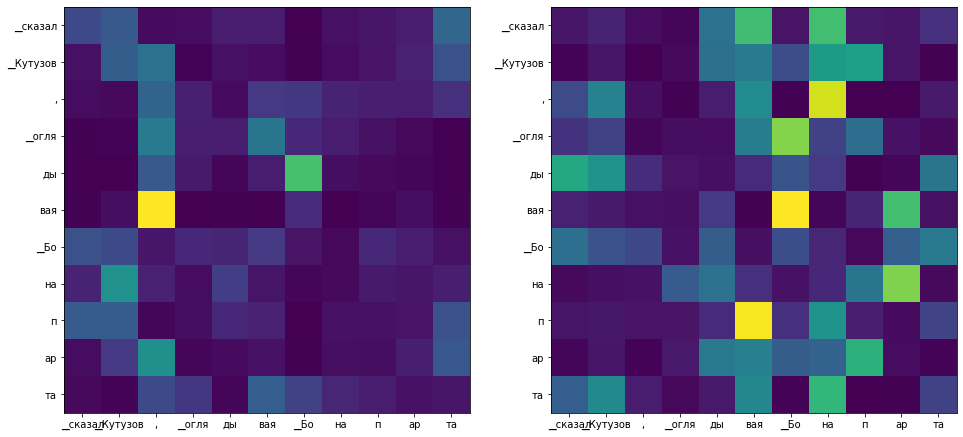

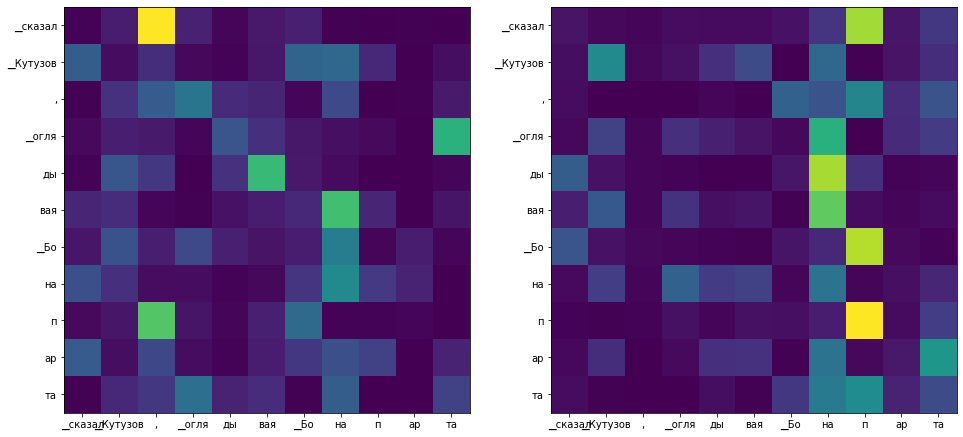

In [90]:
plot_attention_maps(my_transf_model, 'сказал Кутузов, оглядывая Бонапарта', tokenizer)